In [1]:
import numpy as np
import pandas as pd

import skimage.measure

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle

%matplotlib inline 

In [5]:
a = 0.4
b = 0.1
gap = 0.2

P = np.array( [
    [a + gap, b, 0, 0, 0, 0, 0, 0, b],
    [b, a, b, 0, 0, 0, 0, 0, 0],
    [0, b, a, b, 0, 0, 0, 0, 0],
    [0, 0, b, a, b, 0, 0, 0, 0],
    [0, 0, 0, b, a, b, 0, 0, 0],
    [0, 0, 0, 0, b, a, b, 0, 0],
    [0, 0, 0, 0, 0, b, a, b, 0],
    [0, 0, 0, 0, 0, 0, b, a, b],
    [b, 0, 0, 0, 0, 0, 0, b, a] 
]) 

# P = np.maximum(0, P - 1./6) 

Q = np.vstack( [ np.zeros(10), np.hstack( [ (1 - np.sum(P, axis = 1)).reshape(-1,1), P] )])

T = 30000

D = 100

rho = np.max( np.sum(P, axis = 0) ) 

In [3]:
def random_walk( Q, i ):
    
    traj = [i]
    
    counter = 0
    
    next_s = i
    
    while True:
        
        counter += 1
                
        next_s = np.random.multinomial(1, Q[next_s], size=1)
                
        next_s = list(next_s[0]) 
        next_s = next_s.index(1) 
        
        traj.append(next_s) 
        
        if next_s == 0:
            break
            
    return traj

In [4]:
def traj_to_h(trajs, replace = np.inf):
    
    hs = [ ]
    
    for traj in trajs:
        
        h = []
        
        for v in range(1,10): 
            if v in traj:
                h.append( len(traj) - traj.index(v) ) 
            else:
                h.append(replace)
                
        hs.append(h)
    return hs 

# stochastic 

In [176]:
Hs = np.sum( np.linalg.inv( np.identity(9) - P ), axis = 1 ) 
best_H = np.max( Hs ) 

In [259]:
Hs

array([3.86729595, 2.73459189, 2.54025541, 2.50694059, 2.50138812,
       2.50138812, 2.50694059, 2.54025541, 2.73459189])

In [255]:
regrets = [] 

for i in range(10): 
    
    nodes = pickle.load(open( './raw_data/nodes_UCB_{}'.format(0), 'rb' )) 
    
    regrets_tmp = [] 

    for V in nodes: 

        regrets_tmp.append(best_H - Hs[ np.array(V) - 1 ]) 

    regrets.append(regrets_tmp) 

In [256]:
regrets = np.cumsum( regrets , axis = 1 )

regrets_sto = np.mean(regrets, axis = 0) 
regrets_sto_std = np.std(regrets, axis = 0) 



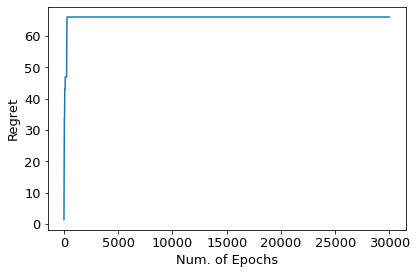

In [258]:
plt.rcParams['font.size'] = 13 

l1, = plt.plot(regrets_sto, label = 'Alg 2') 
plt.fill_between(len(regrets_sto), regrets_sto - regrets_sto_std, regrets_sto+regrets_sto_std, alpha = 0.2) 

# l2, = plt.plot(regrets_standard_mean, label = 'Standard EXP3') 
# plt.fill_between(range(20000), regrets_standard_mean-regrets_standard_std, regrets_standard_mean+regrets_standard_std, alpha = 0.2) 

# plt.legend(handles = [l1,l2]) 

plt.ylabel('Regret') 

plt.xlabel('Num. of Epochs') 

plt.tight_layout()

plt.savefig('sto.png', dpi = 150) 

In [282]:
hss = [] 

errors = []

for i in range(10): 
    
    hs = pickle.load(open( './raw_data/est_UCB_{}'.format(0), 'rb' )) 
    
    errors.append( np.sum( ( np.array(hs) - Hs )**2, axis = 1 ) )
    
    hss.append(hs) 

In [283]:
errors = np.mean( errors , axis = 0 )

In [284]:
plt.rcParams['font.size'] = 13 



plt.plot( errors )

plt.ylabel('Est. Error') 

plt.xlabel('Num. of Epochs') 

plt.tight_layout() 

plt.savefig('sto_errors.png', dpi = 150) 

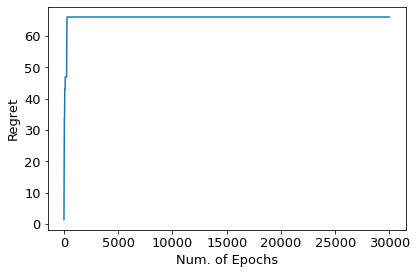

In [261]:
plt.rcParams['font.size'] = 13 

l1, = plt.plot(regrets_sto, label = 'Alg 2') 
plt.fill_between(len(regrets_sto), regrets_sto - regrets_sto_std, regrets_sto+regrets_sto_std, alpha = 0.2) 

# l2, = plt.plot(regrets_standard_mean, label = 'Standard EXP3') 
# plt.fill_between(range(20000), regrets_standard_mean-regrets_standard_std, regrets_standard_mean+regrets_standard_std, alpha = 0.2) 

# plt.legend(handles = [l1,l2]) 

plt.ylabel('Regret') 

plt.xlabel('Num. of Epochs') 

plt.tight_layout() 

In [262]:
Hs - 

array([3.86729595, 2.73459189, 2.54025541, 2.50694059, 2.50138812,
       2.50138812, 2.50694059, 2.54025541, 2.73459189])

# adversarial 

In [200]:
regrets_standard = []

for i in range(10): 
    
    Vs = pickle.load( open('./raw_data/nodes_adversarial_standard_{}'.format(i), 'rb' ) ) 
    hs_true = pickle.load( open('./raw_data/hs_true_adversarial_standard_{}'.format(i), 'rb' ) ) 
    
    reward_policy = [] 
    reward_opt = [] 
    
    for j in range(len(Vs)): 
    
        reward_policy.append( hs_true[j][ Vs[j] - 1 ] ) 

        reward_opt.append( hs_true[j][0] ) # 0 is the optimal node

    regret = np.cumsum( np.array(reward_opt) - np.array(reward_policy) )[:] 
    
    regrets_standard.append(regret) 

In [201]:
regrets_new = []

for i in range(10): 
    
    Vs = pickle.load( open('./raw_data/nodes_adversarial_{}'.format(i), 'rb' ) ) 
    hs_true = pickle.load( open('./raw_data/hs_true_adversarial_{}'.format(i), 'rb' ) ) 
    
    reward_policy = [] 
    reward_opt = []
    
    for j in range(len(Vs)): 
    
        reward_policy.append( hs_true[j][ Vs[j] - 1 ] ) 

        reward_opt.append( hs_true[j][0] ) # 0 is the optimal node

    regret = np.cumsum( np.array(reward_opt) - np.array(reward_policy) )[:] 
    
    regrets_new.append(regret) 

In [202]:
regrets_new_mean = np.mean(regrets_new, axis = 0) 
regrets_new_std = np.std(regrets_new, axis = 0) 

regrets_standard_mean = np.mean(regrets_standard, axis = 0) 
regrets_standard_std = np.std(regrets_standard, axis = 0) 

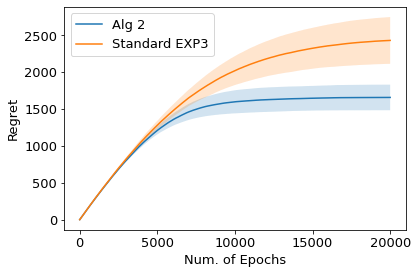

In [229]:
plt.rcParams['font.size'] = 13 

l1, = plt.plot(regrets_new_mean, label = 'Alg 2') 
plt.fill_between(range(20000), regrets_new_mean-regrets_new_std, regrets_new_mean+regrets_new_std, alpha = 0.2) 

l2, = plt.plot(regrets_standard_mean, label = 'Standard EXP3') 
plt.fill_between(range(20000), regrets_standard_mean-regrets_standard_std, regrets_standard_mean+regrets_standard_std, alpha = 0.2) 

plt.legend(handles = [l1,l2]) 

plt.ylabel('Regret') 

plt.xlabel('Num. of Epochs') 

plt.tight_layout()

plt.savefig('adv.png', dpi = 150) 

In [ ]:
reward_policy = []  
reward_opt = []  
j = 0 

for i in range(len(Vs[0])): 
    
    reward_policy.append( hs_true[i][ Vs[0][i] - 1 ] ) 
    
    reward_opt.append( hs_true[i][j] ) 